In [63]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm


import sklearn, sklearn.linear_model, sklearn.metrics, sklearn.pipeline,sklearn.ensemble

import matplotlib
import scipy.stats

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'Species-aware-tempscale':"#E69F00",'Species-agnostic-tempscale':"#56B4E9",
                'DNABERT':"#CC79A7", '11-mer':"#F0E442",'PhyloP100':"#0072B2",'PhyloP240':"#D55E00"}

In [103]:
#10th and 90th percentiles of reference score

percentiles_models = {"Species-agnostic":[0.166,0.552],"Species-aware":[0.167,0.552],
                      "DNABERT":[0.16,0.689],"11-mer":[0.166,0.489],"PhyloP100":[-0.877,2.03],"PhyloP241":[-0.912,3.04],} 

#1st and 99th percentiles of reference score

#percentiles_models = {"Species-agnostic":[0.0498,0.98],"Species-aware":[0.0544,0.982],"DNABERT":[0.0379,0.985],"11-mer":[0.0569,0.842],
#                      "PhyloP100":[-2.68,5.57],"PhyloP241":[-3.59,7.06],} 

In [104]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/'

In [105]:
utr_variants = pd.read_csv(data_dir + 'clinvar/model_scores.tsv.gz', sep='\t')

In [106]:
#utr_variants = utr_variants[utr_variants.vartype=='SNP']

In [107]:
def get_contig_table(model, min_AF_common = 0.05, max_AC_rare = 1):
    if 'Species' in model or model=='DNABERT':
        score = utr_variants[f'{model}_ref']
    else:
        score = utr_variants[model]

    #perc_low = np.nanpercentile(score,10)
    #perc_high = np.nanpercentile(score,90)

    perc_low, perc_high = percentiles_models[model]

    pathogenic_bottom = ((score<perc_low)&(utr_variants.label==1)).sum()
    pathogenic_top = ((score>perc_high)&(utr_variants.label==1)).sum()
    
    benign_bottom = ((score<perc_low)&(utr_variants.label==0)).sum()
    benign_top = ((score>perc_high)&(utr_variants.label==0)).sum()

    contig_table = [[pathogenic_top,benign_top], [pathogenic_bottom,benign_bottom] ]

    return contig_table, score

In [108]:
models = ('PhyloP100','PhyloP241','Species-aware','Species-agnostic','DNABERT','11-mer')

In [109]:
odds_ratios = []
score = {}

for model in models:
    contig_table, score[model] = get_contig_table(model)
    fisher_test = scipy.stats.fisher_exact(contig_table)
    print(model,contig_table, fisher_test)
    odds_ratios.append((model, fisher_test.statistic))

odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR']).sort_values(by='OR', ascending=False)
odds_ratios.loc[odds_ratios.model=='PhyloP241','model'] = 'PhyloP240'

PhyloP100 [[132, 718], [10, 2356]] SignificanceResult(statistic=43.31364902506964, pvalue=8.242034909264941e-67)
PhyloP241 [[124, 892], [14, 1829]] SignificanceResult(statistic=18.16111467008328, pvalue=2.5009580832458577e-42)
Species-aware [[14, 938], [30, 3311]] SignificanceResult(statistic=1.6472636815920398, pvalue=0.14266458793632236)
Species-agnostic [[15, 914], [36, 3367]] SignificanceResult(statistic=1.5349197665937273, pvalue=0.1702278507412036)
DNABERT [[0, 138], [15, 831]] SignificanceResult(statistic=0.0, pvalue=0.24867483874990481)
11-mer [[8, 910], [46, 3135]] SignificanceResult(statistic=0.5991399904443383, pvalue=0.248460980630686)


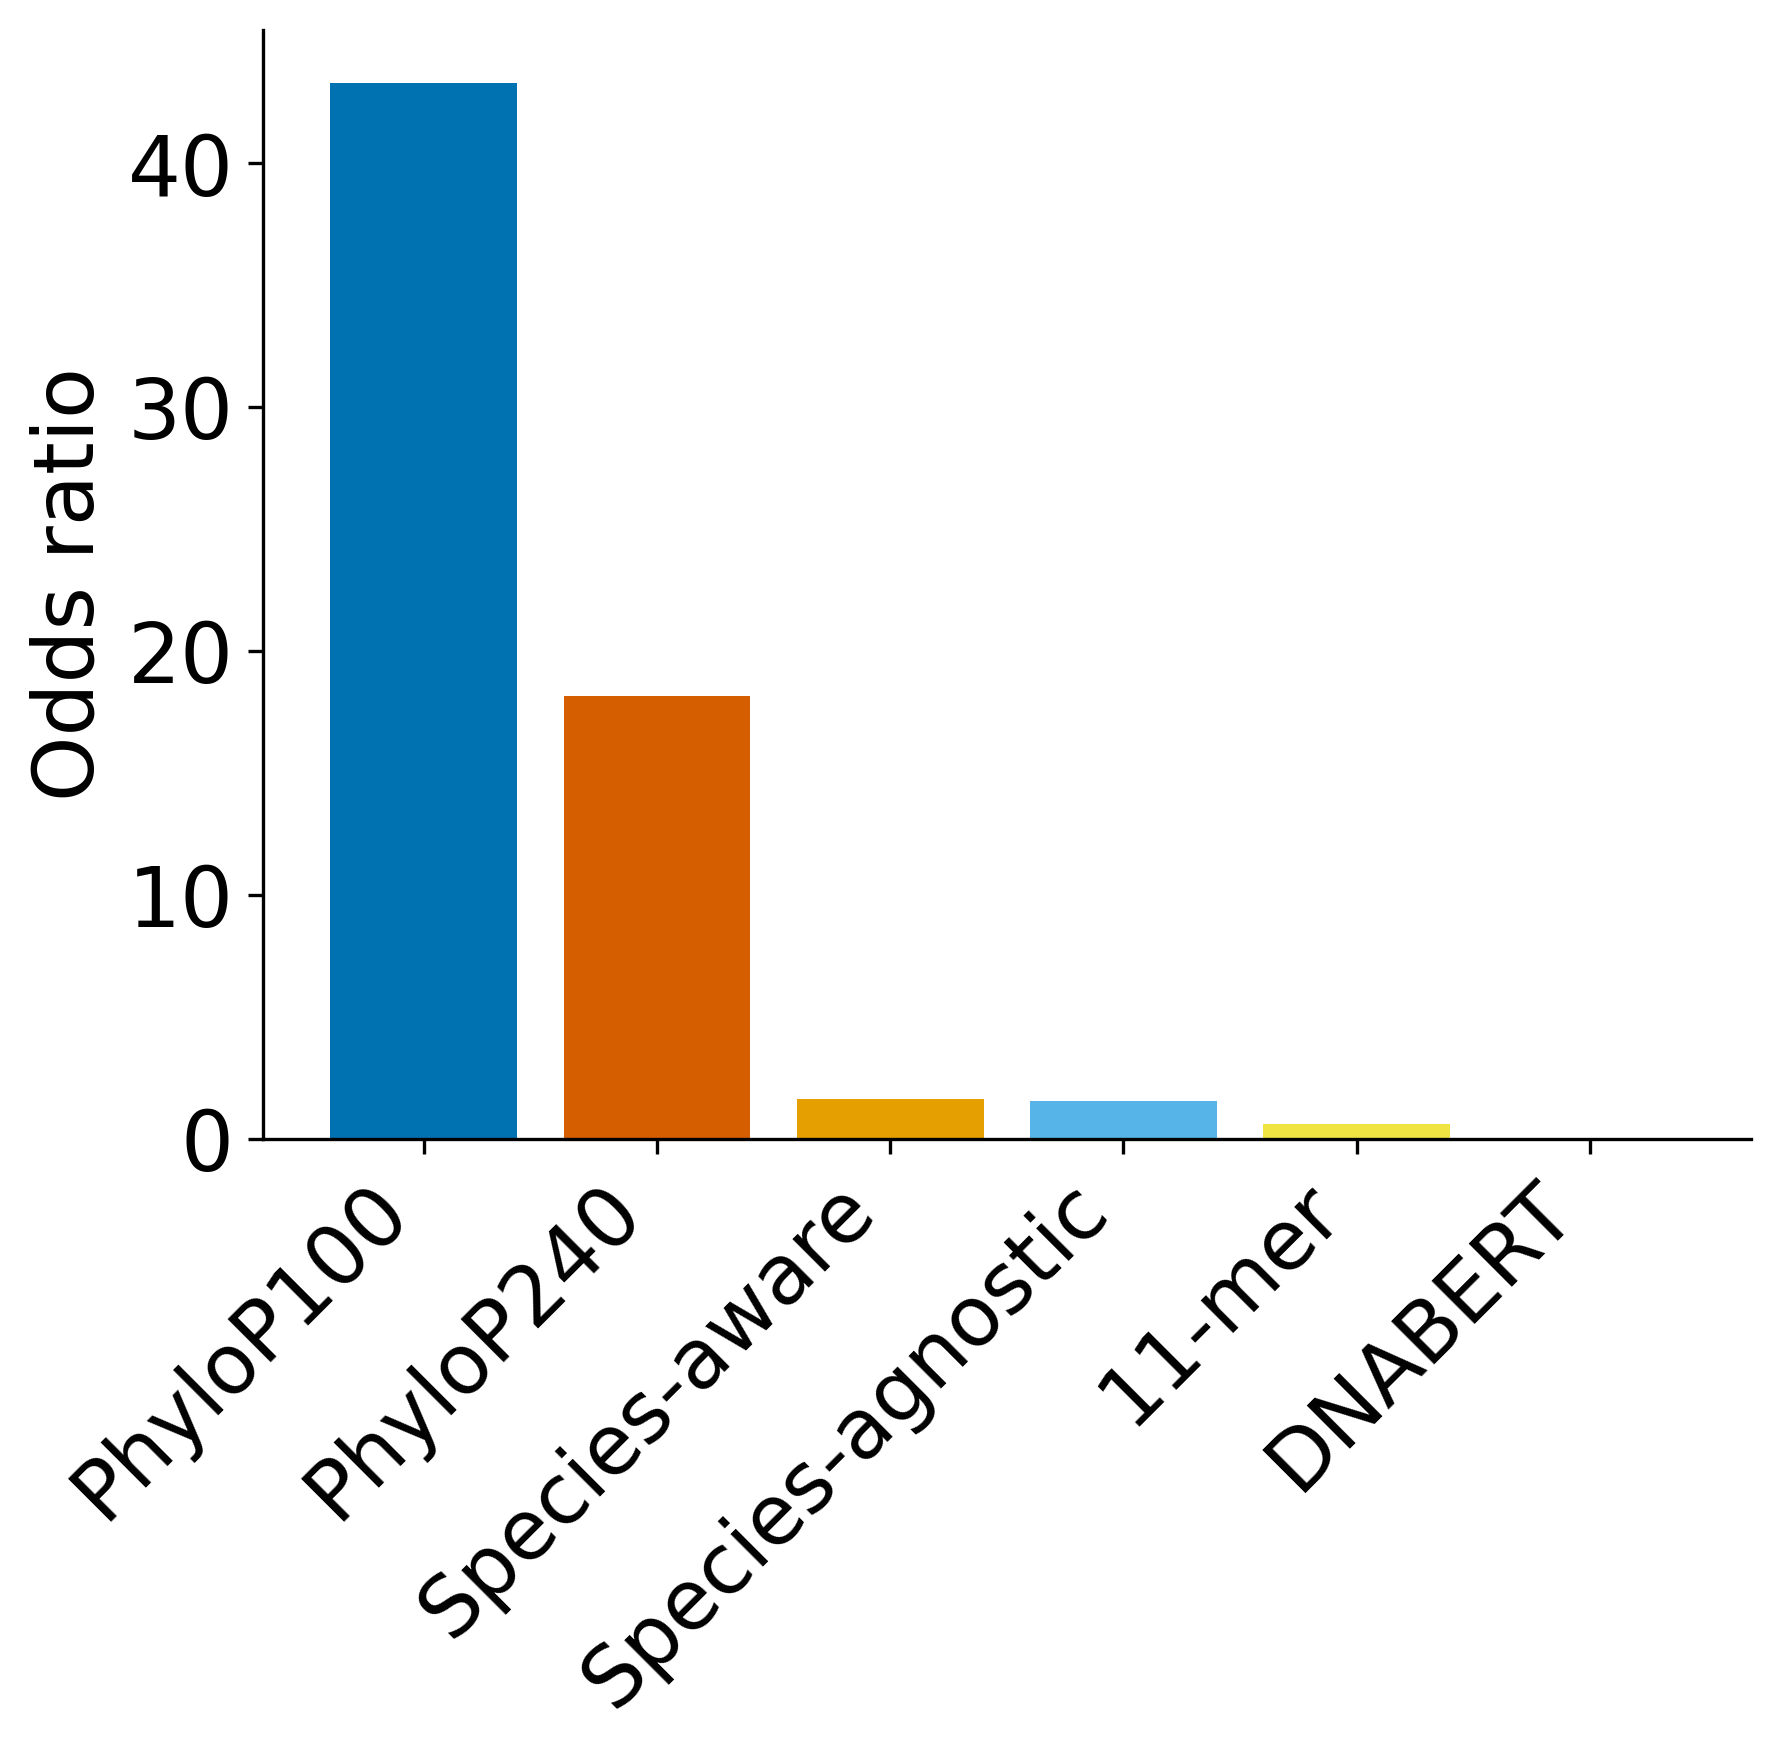

In [110]:
fig, ax = plt.subplots(dpi=300)

ax.bar(odds_ratios.model, odds_ratios.OR, color=odds_ratios.model.map(model_colors))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_yscale('log')

#for model_idx, model in enumerate(models):
#    ax.text(model_idx-0.4, odds[model]+2, f'{odds[model]:.1f}')
#ax.set_ylim([0,260])